In [1]:

# Set up configuration options and special features
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def hw8(N):

    # Initialize parameters (grid spacing, time step, etc.)
    i_imag = 1j  # imaginary i in Python

    # N = eval(input('enter number of grid points: '))
#     N = 100

    L = 100.0  # System extends from -L/2 to L/2
    dx = L / (N - 1)  # Grid size
    x = np.arange(N) * dx - L / 2.0  # Coordinates of grid points.
    hbar = 1.0  # Natural units
    mass = 1.0  # Natural units
    # dt = eval(input('Enter time step: '))
    dt = .01

    # Set up the Hamiltonian operator matrix
    ham = np.zeros((N, N))  # Set all elements to zero.
    coeff = -hbar**2 / (2 * mass * dx**2)

    for i in range(1, N - 1):
        ham[i, i - 1] = coeff
        ham[i, i] = -2 * coeff  # Set interior rows
        ham[i, i + 1] = coeff

    # First and last rows for periodic boundary conditions
    ham[0, -1] = coeff
    ham[0, 0] = -2 * coeff
    ham[0, 1] = coeff

    ham[-1, -2] = coeff
    ham[-1, -1] = -2 * coeff
    ham[-1, 0] = coeff

    # Compute the Crank-Nicolson Matrix
    dCN = np.dot(
        np.linalg.inv(np.identity(N) + 0.5 * i_imag * dt / hbar * ham),
        (np.identity(N) - 0.5 * i_imag * dt / hbar * ham))

    # Initialize the wavefunction
    x0 = 0.0  # Location of the center of the wavepacket
    velocity = 0.5  # Average velocity of the packet
    k0 = mass * velocity / hbar  # Average wavenumber
    sigma0 = L / 10.0  # Standard deviation of the wavefunction
    Norm_psi = 1.0 / np.sqrt(sigma0 * np.sqrt(np.pi))
    psi = np.empty(N, dtype=complex)  # Initialize wavefunction as an array

    psiMom = np.empty(N, dtype=complex)

    for q in range(N):
        psi[q] = Norm_psi * np.exp(i_imag * k0 * x[q]) * np.exp(
            -(x[q] - x0)**2 / (2 * sigma0**2))

        psiMom[q] = -i_imag * hbar * N**2 * np.exp(
            -(x[q] - x0)**2 / (sigma0**2)) * (i_imag * k0 -
                                              (x[q] - x0) / sigma0**2)

    # Plot the initial wavefunction
    fig, ax = plt.subplots()
    ax.plot(x, np.real(psi), ls='-', label='Real')
    ax.plot(x, np.imag(psi), ls='--', label='Imag')
    ax.set_xlabel('x')
    ax.set_ylabel(r'$\psi(x)$')
    ax.set_title(
        r'Initial Wavefunction, N = {0:d}, $\Delta t = ${1:.2f}'.format(N, dt))
    ax.legend()

    plt.show()

    # Initialize loop and plotting variables
    max_iter = int(
        L / (velocity * dt) + 0.5
    )  # Max iterations such that the particle circles the system at least once
    plot_iter = max_iter / 8
    p_plot = np.empty(
        (N, max_iter + 1))  # Note probability density P(x,t) is real
    p_plot[:, 0] = np.abs(psi)**2  # Record initial probability density
    iplot = 0

    # Loop over desired number of steps (wave circles the system once)
    for iter in range(max_iter):

        # Compute new wavefunction using the Crank-Nicoloson method
        psi = np.dot(dCN, psi)

        # Normalize after every time step to help with truncation errors.
        norm = dx * np.sum(np.abs(psi)**2)
        psi = psi / np.sqrt(norm)

        # Periodically record values for plotting
        if (iter + 1) % plot_iter < 1:
            iplot += 1
            p_plot[:, iplot] = np.abs(psi)**2
            norm_check = dx * np.sum(
                np.abs(psi)**
                2)  # This should always be one. If it's not, you have a bug.
            print(
                ('Finished {0:d} of {1:d} iterations.'.format(iter, max_iter)))
            print('WF Norm: {0:.2f}'.format(norm_check))

    # Plot probability vs. position at various times.
    pFinal = np.abs(psi)**2

#     fig2, ax2 = plt.subplots()
#     ax2.plot(x,
#              p_plot[:, 0],
#              ls=':',
#              color='black',
#              linewidth=1.75,
#              label='Initial')
#     for m in range(1, iplot + 1):
#         ax2.plot(x, p_plot[:, m], label='_nolegend_'
#                  )  # No legend labels for all the intermediate time plots
#     ax2.plot(x, pFinal, ls='--', color='k', linewidth=1.75, label='Final')
#     ax2.set_xlabel('x')
#     ax2.set_ylabel('P(x,t)')
#     ax2.set_xlim(-L / 2.0, L / 2.0)
#     ax2.set_ylim(0.0, 1.1 * max(p_plot[:, 0]))
#     ax2.set_title(
#         'Probability density at various times. N = {0:d}, $\Delta t = ${1:.3f}'
#         .format(N, dt))
#     ax2.legend()

#     plt.show()
    
    x = psiMom.sum()
#     print(type(x))
#     print(x.real)
#     print(x.imag)
    momVal = np.sqrt(x.real**2 + x.imag**2)
#     print(momVal)
    return(momVal)

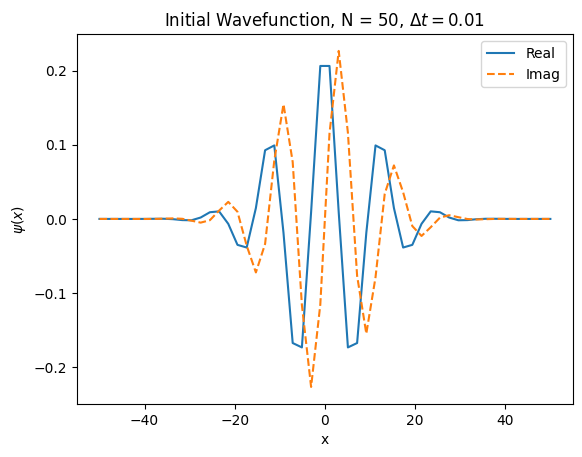

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
10856.279836791406


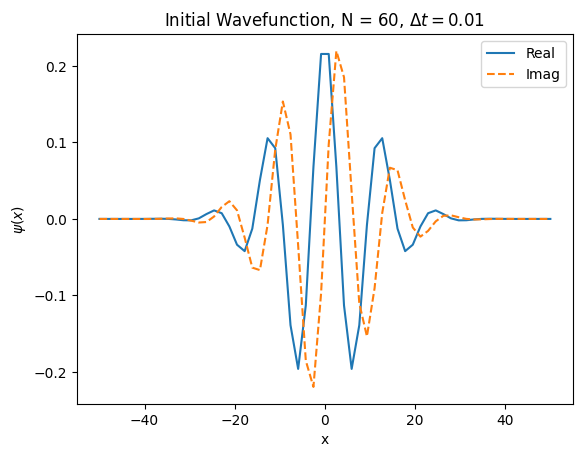

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
18823.459896605877


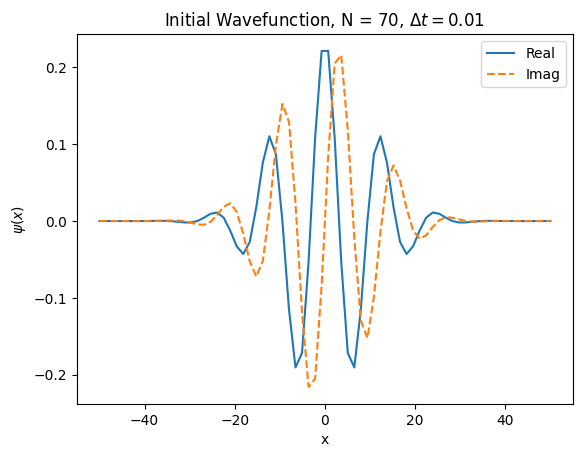

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
29963.332349537744


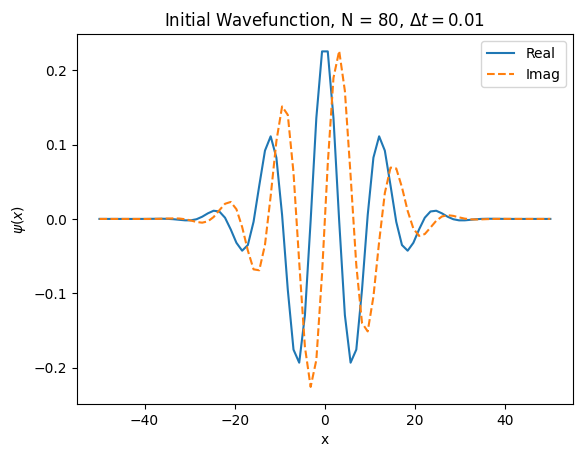

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
44807.63335085784


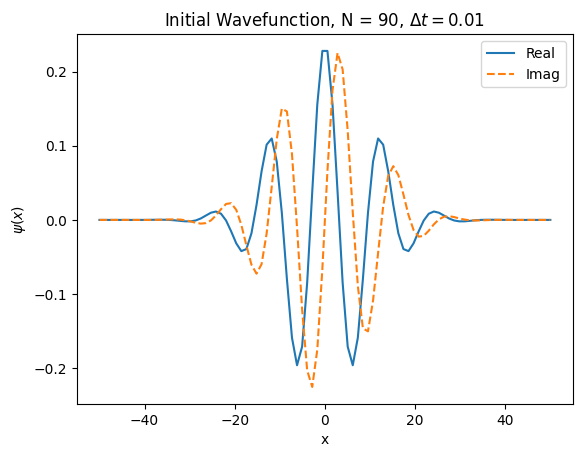

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
63888.09905583702


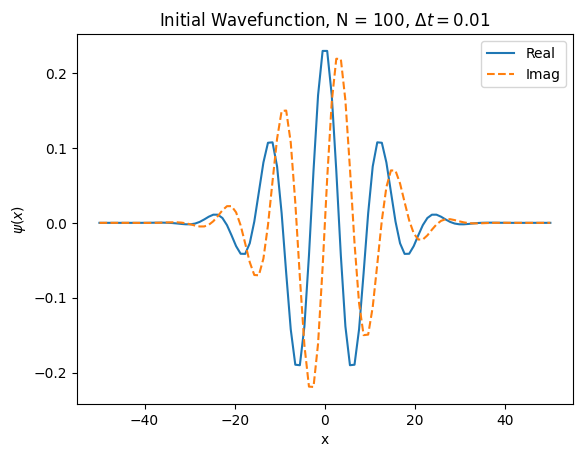

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
87736.46561974609


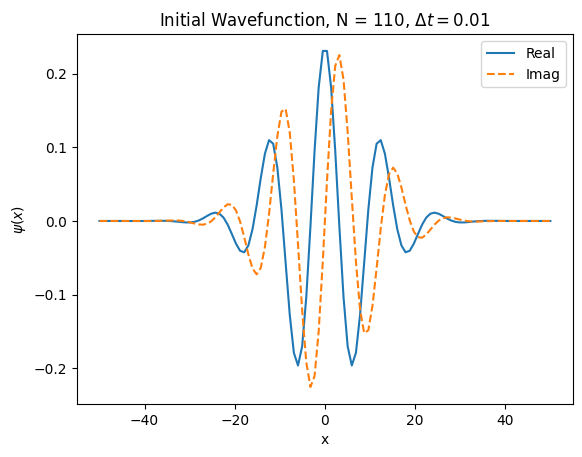

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
116884.46919785587


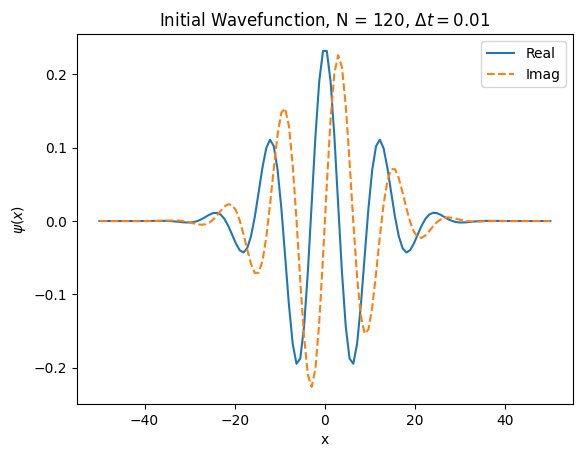

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
151863.84594543726


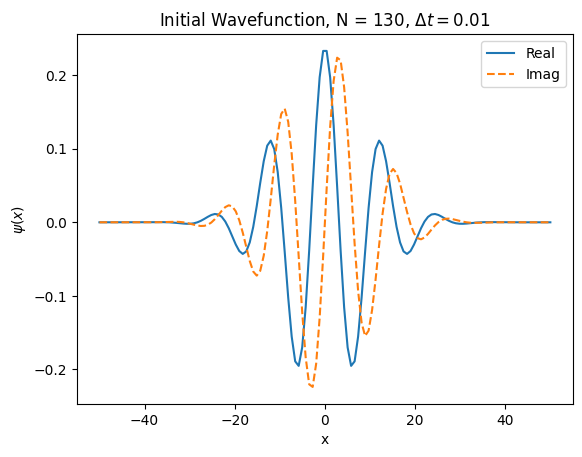

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
193206.33201776101


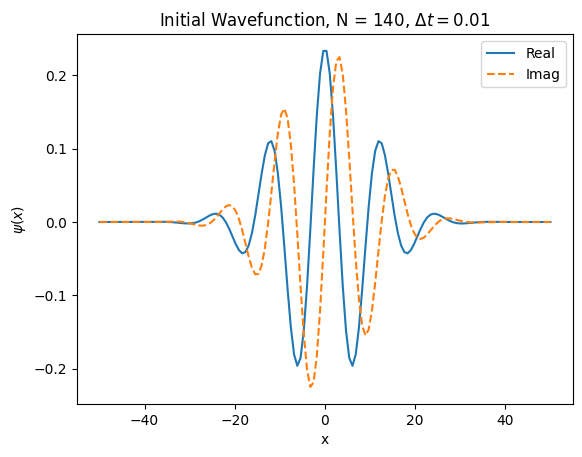

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
241443.6635700981


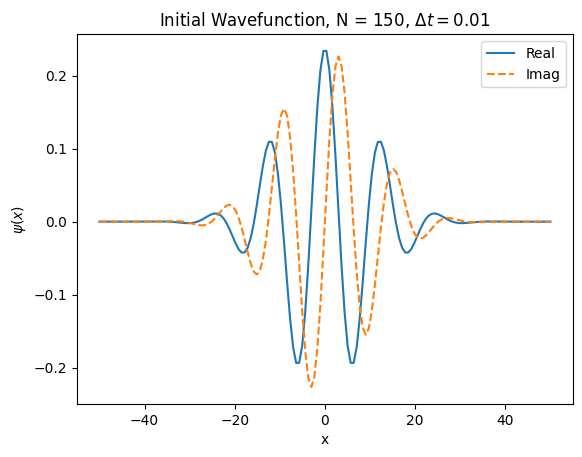

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
297107.5767577192


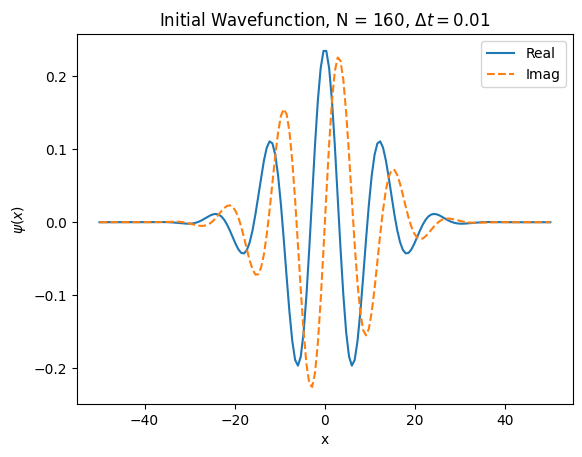

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
360729.8077358953


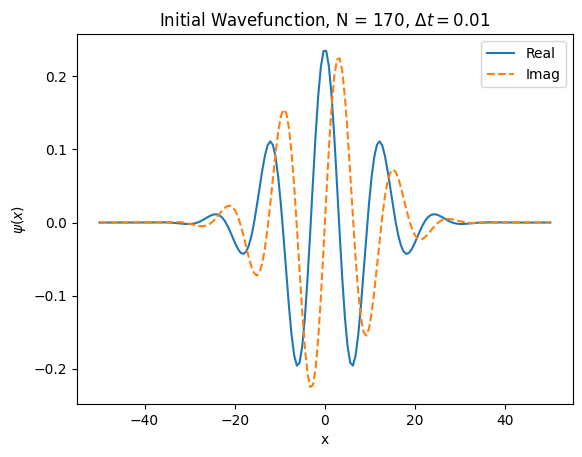

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
432842.09265989705


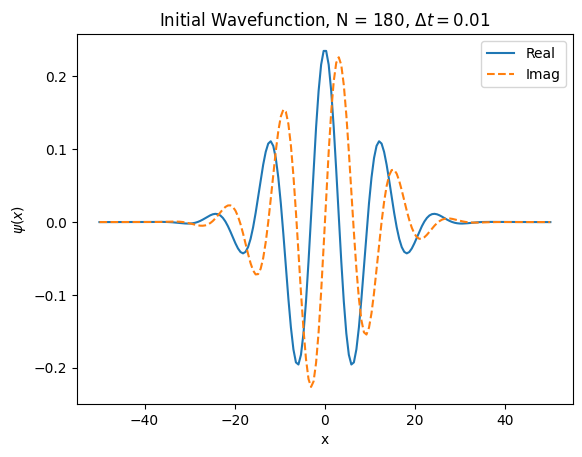

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
513976.16768499545


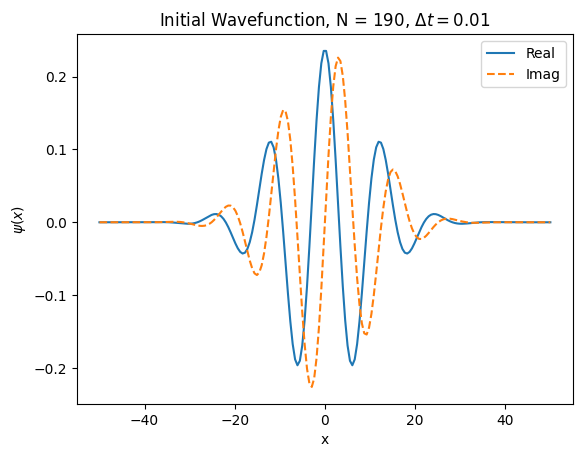

Finished 2499 of 20000 iterations.
WF Norm: 1.00
Finished 4999 of 20000 iterations.
WF Norm: 1.00
Finished 7499 of 20000 iterations.
WF Norm: 1.00
Finished 9999 of 20000 iterations.
WF Norm: 1.00
Finished 12499 of 20000 iterations.
WF Norm: 1.00
Finished 14999 of 20000 iterations.
WF Norm: 1.00
Finished 17499 of 20000 iterations.
WF Norm: 1.00
Finished 19999 of 20000 iterations.
WF Norm: 1.00
604663.7689664613


In [3]:
for i in np.arange(50, 200, 10):
    print(hw8(i))